# Illegal Logging Detection
<h4>Blake Rayvid - <a href=https://github.com/brayvid>https://github.com/brayvid</a></h4>

# Feature extraction

In [2]:
import os
import numpy as np
import librosa
import logging

logging.basicConfig(level=logging.DEBUG)

def extract_features(file_path, max_len=200):
    try:
        logging.debug(f"Attempting to load {file_path}")

        # Load the audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        logging.debug(f"Loaded {file_path}: audio shape {audio.shape}, sample rate {sample_rate}")

        # Generate Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
        logging.debug(f"Generated Mel-spectrogram for {file_path}: shape {mel_spectrogram.shape}")

        # Convert power spectrogram to decibel units
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        logging.debug(f"Converted Mel-spectrogram to dB for {file_path}: shape {log_mel_spectrogram.shape}")

        # Pad or truncate Mel-spectrogram to ensure consistent length
        if log_mel_spectrogram.shape[1] < max_len:
            pad_width = max_len - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :max_len]

        return log_mel_spectrogram

    except FileNotFoundError:
        logging.error(f"File not found: {file_path}")
        return None
    except ValueError as ve:
        logging.error(f"Value error while processing file {file_path}: {ve}")
        return None
    except Exception as e:
        logging.error(f"Error processing file {file_path}: {e}")
        return None

def load_data(data_dir, max_len=200):
    features = []
    labels = []
    class_names = ['chainsaw', 'non_chainsaw']

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.endswith('.wav'):
                data = extract_features(file_path, max_len=max_len)
                if data is not None:
                    features.append(data)
                    labels.append(class_name)

    return np.array(features), np.array(labels)

# Example usage
data_dir = '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/data'
max_len = 200  # or adjust this to a suitable length based on your dataset
X, y = load_data(data_dir, max_len=max_len)

if len(X) == 0:
    logging.error("No valid features extracted. Please check your audio files and directory structure.")
else:
    logging.info(f"Extracted features from {len(X)} files.")

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input shape: (number of samples, frequency bins, time frames, 1)
input_shape = (128, X_train.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], 128, X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], 128, X_test.shape[2], 1)

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 99, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 99, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 48, 64)        0         
 g2D)                                                            
                                                        

# Evaluate model

13/13 - 7s - loss: 0.1275 - accuracy: 0.9950 - 7s/epoch - 560ms/step
Test accuracy: 0.9950


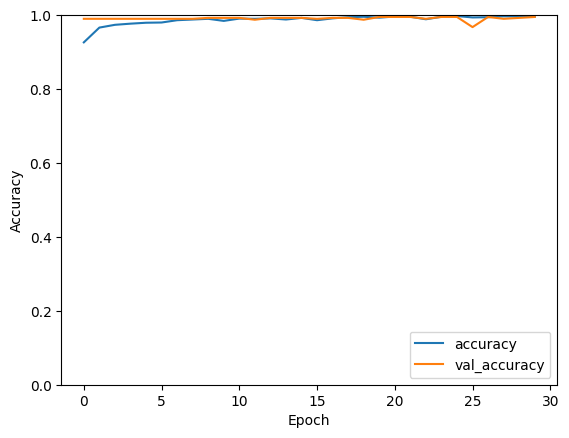

In [4]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()